In [1]:
import os
import glob
import logging
from scipy.signal import butter, filtfilt
import pandas as pd 
import numpy as np
from experiments.test.experiment_design import NeonatalPainFaces
from common.pupillary_analysis import PupillaryAnalysis as pupil
from concurrent.futures import ThreadPoolExecutor

log_file = 'test.log'
log_level = logging.INFO
log_format = '%(asctime)s - %(levelname)s - %(message)s'

# Configure logging
logging.basicConfig(filename=log_file, level=log_level)
def lowpass_filter(data, cutoff, fs, padlen=34, order=5):
        if len(data) < padlen:
            # Adicionar zero padding no início e no final do sinal
            data_padded =  np.pad(data, (34-len(data), 0), mode='constant')
        else:
            data_padded = data
        # Calcular a frequência de corte em relação à frequência de Nyquist
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist

        # Projetar o filtro Butterworth
        b, a = butter(order, normal_cutoff, btype='low', analog=False)

        # Aplicar o filtro ao sinal de dados
        filtered_data = filtfilt(b, a, data_padded)

        return filtered_data
    
def process_stimulus(stimulus_data, participant_id, participant_group, fs=300):
    """
    get stimuli features
    """
    global t1, t2
   
   
    # linear interpolate pupil signal
    stimulus_data[['PupilRight','PupilLeft']] = stimulus_data[['PupilRight','PupilLeft']].interpolate(limit_direction='both')
    # stimulus_data['pupil_mean'] = stimulus_data[['PupilRight','PupilLeft']].mean(axis=1)
    # iv = raw_data['pupil_mean'].first_valid_index()
    try:
        stimulus_data['PupilRight'] = lowpass_filter(stimulus_data['PupilRight'],1.6,300)
    except Exception as e: 
        logging.error(f"Error processing lowpass_filter: {str(e)}")
    
    iv = stimulus_data['PupilRight'].first_valid_index()
    baseline  = stimulus_data['PupilRight'].loc[iv].mean()

    # number of samples from t1 to t2
    num_samples = int((t2 - t1) * fs / 1000)
    # minimum RecordingTimestamp
    min_timestamp = stimulus_data['RecordingTimestamp'].min()
    # select line corresponding to t1 ms
    idx_min = (stimulus_data['RecordingTimestamp'] >= min_timestamp + t1).idxmax()
    # select line corresponding to t1 ms + num_samples (t2)
    idx_max = idx_min + num_samples
    # get new data
    stimulus_data = stimulus_data.loc[idx_min:idx_max]
    # get features to explore/exploit ratio
    try:
        stimulus_features = pd.DataFrame({
            "participant_group": [participant_group],
            "participant_id": [participant_id],
            "count_fixation": [stimulus_data['FixationIndex'].nunique()],
            "count_saccade": [stimulus_data['SaccadeIndex'].nunique()],
            "fixation_duration":stimulus_data.groupby('FixationIndex')['GazeEventDuration'].unique().sum(),
            "saccade_duration":stimulus_data.groupby('SaccadeIndex')['GazeEventDuration'].unique().sum(),
            "count_short_fixation": stimulus_data.query('GazeEventDuration <= 100')['FixationIndex'].nunique(),
            "count_long_fixation": stimulus_data.query('200 <= GazeEventDuration')['FixationIndex'].nunique(),
            "count_long_saccade": stimulus_data.query('0 <= GazeEventDuration')['SaccadeIndex'].nunique(),
            "pupil_diameter_mean": [(stimulus_data['PupilRight'] - baseline).abs().mean()],
            "pupil_diameter_sum": [(stimulus_data['PupilRight'] - baseline).abs().sum()]
        })
    except Exception as e:
        logging.error(f"Error processing stimulus: {str(e)}")
    return stimulus_features
    

def process_file(file):
    """
    read data file
    """
    global eer_data, exp

    # Read data from the CSV file
    raw_data = pd.read_csv(file, delimiter=',', low_memory=False)
    
    # Select specific columns of interest
    raw_data = raw_data[[
        'ParticipantName',        # Tobii participant's ref
        'MediaName',              # Name of the media
        'FixationIndex',          # Index of fixation
        'SaccadeIndex',
        'RecordingTimestamp',     # Timestamp of recording
        'GazeEventDuration',      # Duration of gaze event
        'PupilRight',             # Right eye pupil data
        'PupilLeft',              # Left eye pupil data
        'AOI'                     # Area of Interest (AOI)
    ]]

    raw_data = raw_data[raw_data['MediaName'].isin(exp.stimuli)]
    # Extract participant ID from the first row of data
    participant_id = raw_data['ParticipantName'].iloc[0]
    participant_group = os.path.split(file)[-2].split('\\')[-1]

    if participant_group == 'doctors': participant_group = 'experts'

    try:
        stimulus_features = raw_data.groupby(['MediaName']).apply(
            process_stimulus, participant_id, participant_group, include_groups=False)
        
        eer_data.append(stimulus_features.reset_index('MediaName'))
    except Exception as e:
        logging.error(f"Error processing file {file}: {str(e)}")

   
eer = []
t = [(0,2000), (2000,7000)]  
for ti in t:
    eer_data = [] 
    t1, t2 = ti[0], ti[1]
    exp_name = 'neonatal_pain_faces'
    excluded_class = 'other-health-professionals'
    path_to_dataset = f'experiments/{exp_name}/db/'
    output_dir = f'experiments/{exp_name}/db_processed/'

    exp = NeonatalPainFaces(path_to_dataset=path_to_dataset, output_dir=output_dir)

    files = glob.glob(os.path.join(output_dir, '**/*.tsv'), recursive=True)
    files = [file for file in files if excluded_class not in file]

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        executor.map(process_file, files)
    eer.append(pd.concat(eer_data))

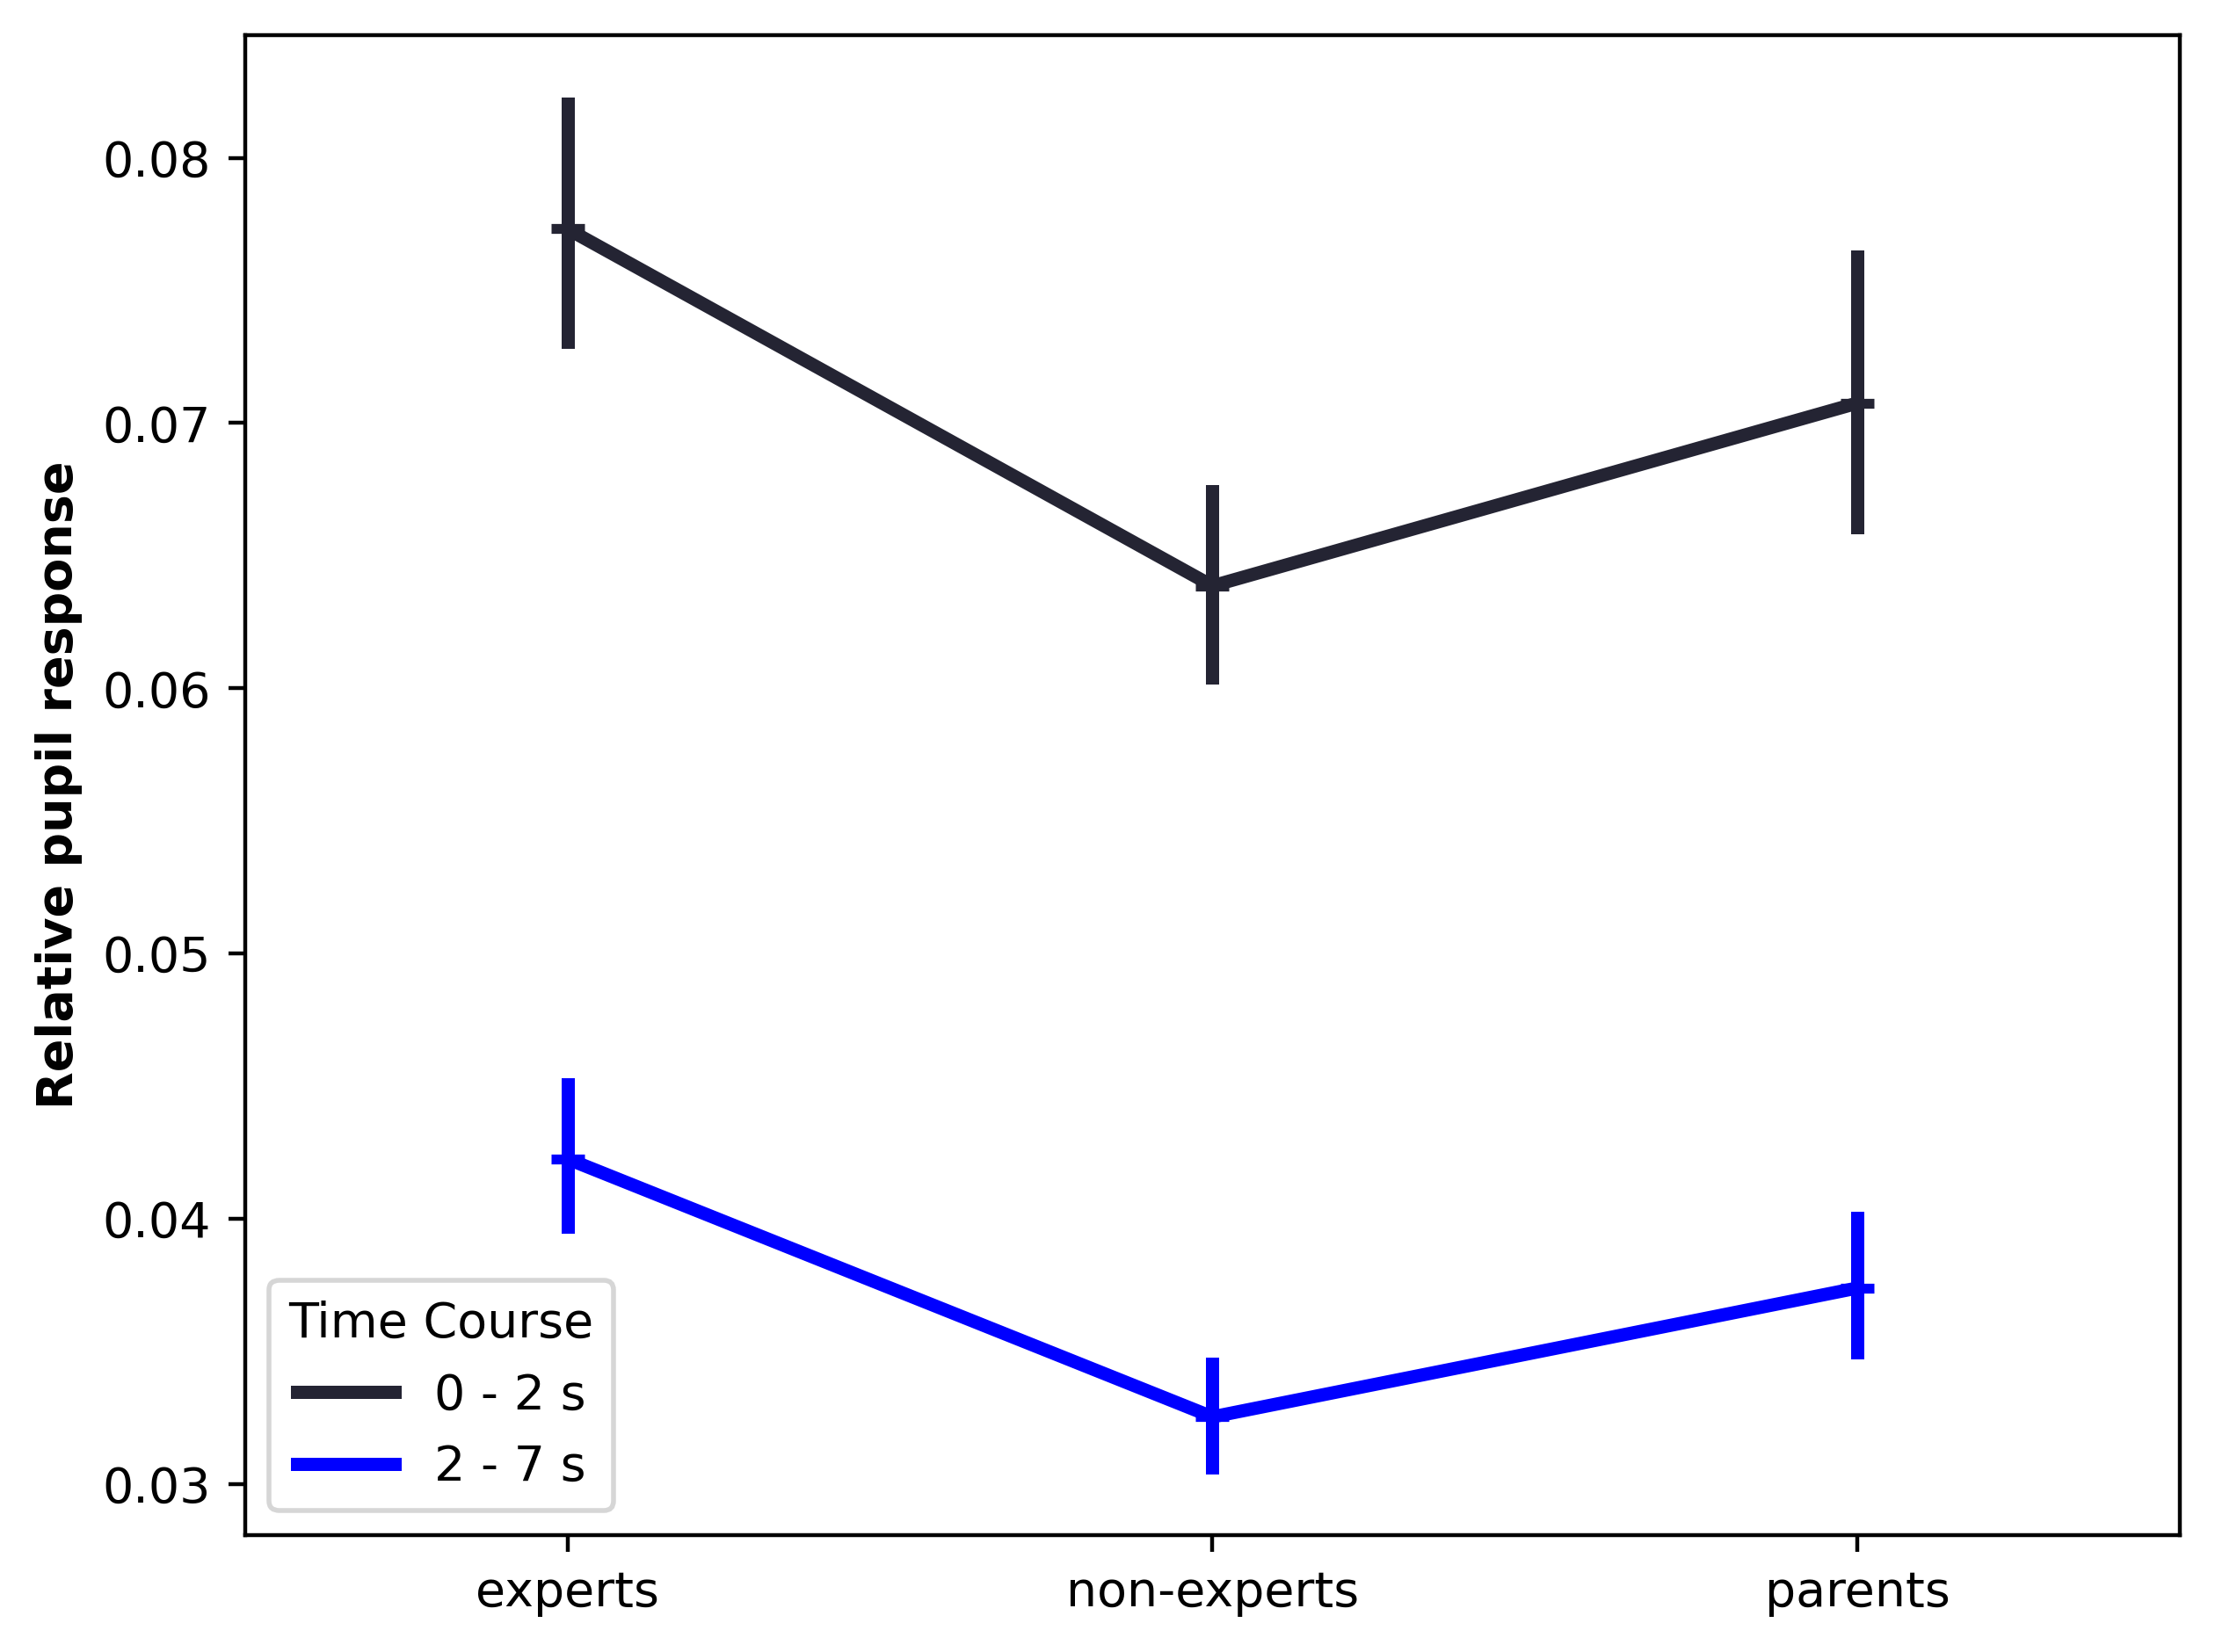

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pp_d = 'pupil_diameter_mean'
plt_err = []
for ed in eer:
    er = ed.copy() 
    explore = er['count_short_fixation']
    exploit = er['count_long_fixation']
    er['ee_ratio'] = explore/(explore + exploit)
    plt_err.append(er)

plt_err[0][pp_d] = plt_err[0][pp_d]/((t[0][1]-t[0][0])/1000)
plt_err[1][pp_d] = plt_err[1][pp_d]/((t[1][1]-t[1][0])/1000)


plt_err[0]['Time Course'] = '0 - 2 s'
plt_err[1]['Time Course'] = '2 - 7 s'
combined_df = pd.concat(plt_err)

fig = plt.figure(dpi=400) 
sns.pointplot(data=combined_df, x='participant_group', y=pp_d, hue='Time Course', color='b', markers='_')
# sns.pointplot(data=plt_err[2], x='participant_group', y='ee_ratio', color='r', markers='_')


# Ajuste os eixos e adicione um título
plt.xlabel('', fontweight='bold')
plt.ylabel('Relative pupil response', fontweight='bold')
# plt.title('Total pupil diameter variation by Participant Group')
plt.tight_layout()
plt.show()

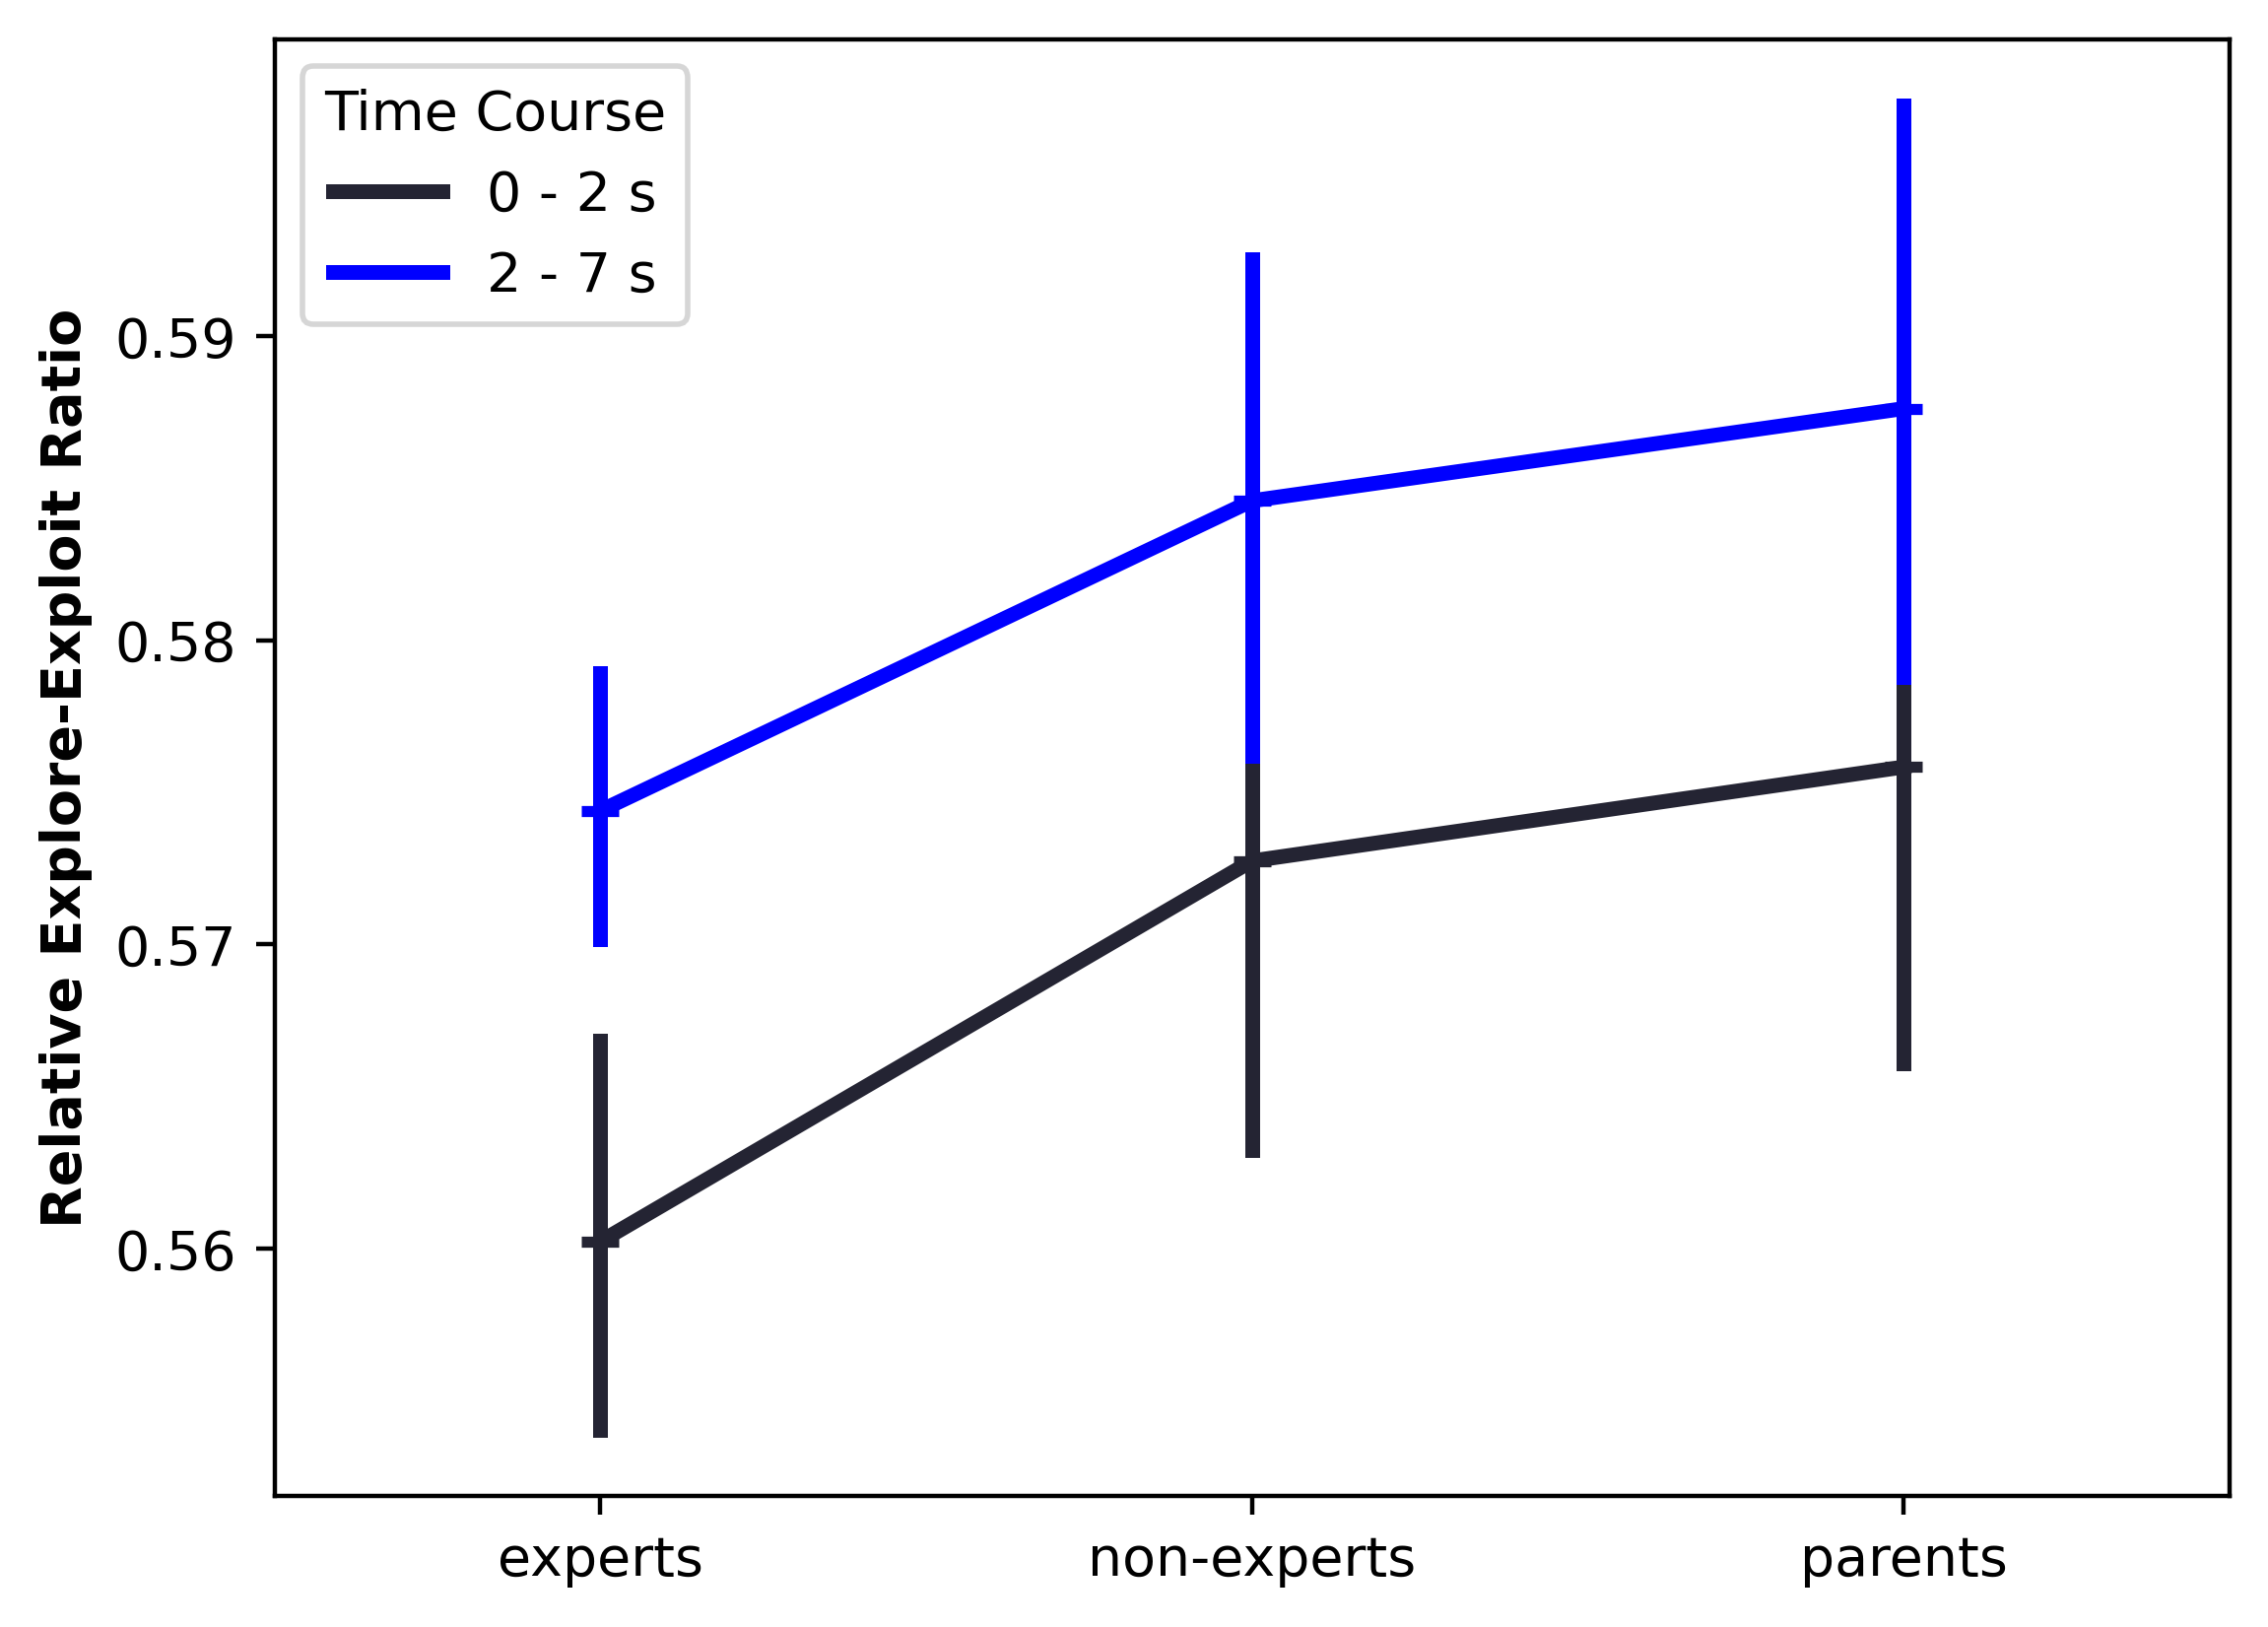

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt_err = []
for ed in eer:
    
    er = ed#.groupby(['participant_group','participant_id','MediaName']).mean()#.groupby(['participant_group','participant_id']).mean()
    explore =  er['count_saccade'] + er['count_short_fixation']
    exploit = er['count_long_fixation']
    er['ee_ratio'] = explore/(explore + exploit)
    plt_err.append(er)


plt_err[0]['ee_ratio'] = plt_err[0]['ee_ratio']
plt_err[1]['ee_ratio'] = plt_err[1]['ee_ratio']

plt_err[0]['Time Course'] = '0 - 2 s'
plt_err[1]['Time Course'] = '2 - 7 s'
combined_df = pd.concat(plt_err).groupby(['Time Course','participant_group','participant_id','MediaName']).mean()

fig = plt.figure(dpi=400)
sns.pointplot(data=combined_df, x='participant_group', y='ee_ratio', hue='Time Course', color='b', markers='_')
# sns.pointplot(data=plt_err[2], x='participant_group', y='ee_ratio', color='r', markers='_')

# Ajuste os eixos e adicione um título
plt.xlabel('', fontweight='bold')
plt.ylabel('Relative Explore-Exploit Ratio', fontweight='bold')
# plt.title('Relative Explore/Exploit by Participant Group')

plt.show()

In [4]:
eer[0].to_csv('4_aoi_data.csv')
eer[1].to_csv('aoi_data_2.csv')